# Построение классификатора УЗИ-снимка груди женщины на наличие и тип опухоли

## Задание 1. Обработка данных и настройка окружения.

### 1.1. Импорт необходимых библиотек

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import time
import copy

In [5]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Для воспроизводимости результатов
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

### 1.2. Загрузка изображений

In [8]:
DATA_DIR = 'Dataset_BUSI_with_GT'

In [9]:
# Определим классы и их соответствие индексам
CLASS_NAMES = ['benign', 'malignant', 'normal']
class_to_idx = {name: i for i, name in enumerate(CLASS_NAMES)}
idx_to_class = {i: name for i, name in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES)

images_data = []
labels_data = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        print(f"Warning: Directory {class_dir} not found. Skipping.")
        continue
    for img_name in os.listdir(class_dir):
        # Игнорируем маски, если они есть (файлы с суффиксом _mask)
        if '_mask' in img_name:
            continue
        img_path = os.path.join(class_dir, img_name)
        try:
            # Загрузка изображения с помощью OpenCV
            img = cv2.imread(img_path)
            if img is not None:
                images_data.append(img)
                labels_data.append(class_to_idx[class_name])
            else:
                print(f"Warning: Could not read image {img_path}. Skipping.")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print(f"Загружено изображений: {len(images_data)}")
print(f"Загружено меток: {len(labels_data)}")
if len(images_data) > 0:
    print(f"Пример размера изображения: {images_data[0].shape}") # (height, width, channels)
else:
    print("Не загружено ни одного изображения. Проверьте путь к датасету и его структуру.")

Загружено изображений: 780
Загружено меток: 780
Пример размера изображения: (471, 562, 3)


### 1.3. Изучение снимков и визуализация

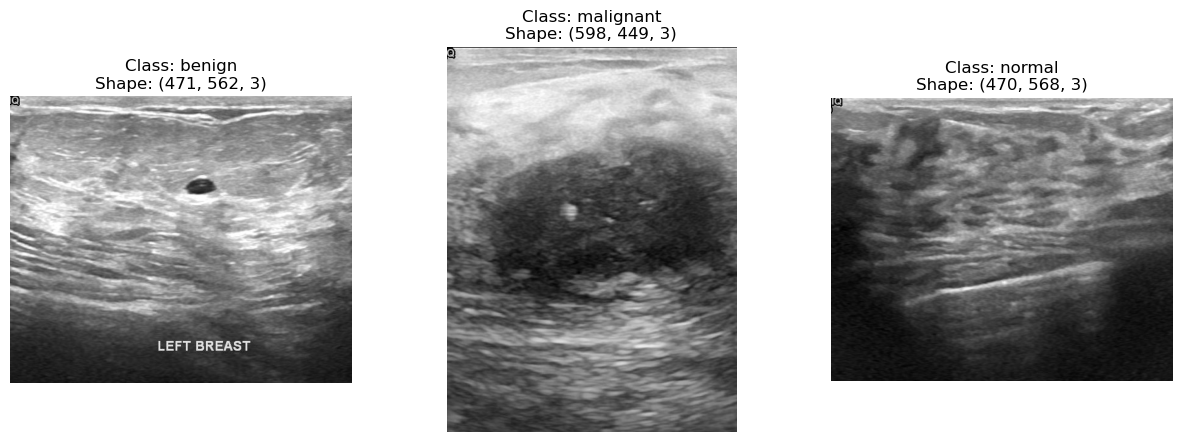

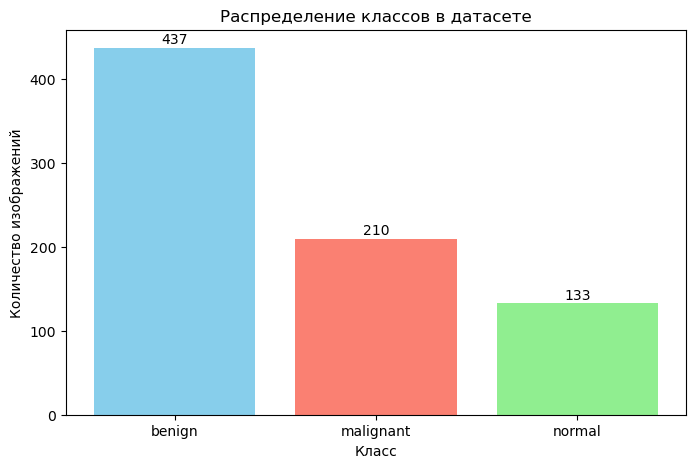

In [11]:
# Визуализируем по одному примеру из каждого класса
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(CLASS_NAMES):
    # Найдем первое изображение этого класса
    try:
        idx_example = labels_data.index(class_to_idx[class_name])
        img_example = images_data[idx_example]
        
        plt.subplot(1, NUM_CLASSES, i + 1)
        # OpenCV загружает в BGR, Matplotlib ожидает RGB
        plt.imshow(cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB))
        plt.title(f"Class: {class_name}\nShape: {img_example.shape}")
        plt.axis('off')
    except ValueError:
        print(f"Не найдено примеров для класса {class_name}")
plt.show()

# Распределение классов
label_counts = np.bincount(labels_data)
plt.figure(figsize=(8, 5))
plt.bar(CLASS_NAMES, label_counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Распределение классов в датасете')
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
for i, count in enumerate(label_counts):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

Мое видение данных:
**Отличия больных от здоровых:**

**Normal (здоровые):** Изображения обычно показывают относительно однородную текстуру ткани молочной железы. Могут присутствовать протоки и соединительная ткань, но без явных очаговых образований.

**Benign (доброкачественные):** Опухоли часто имеют четкие, ровные контуры, овальную или круглую форму. Эхогенность (яркость на УЗИ) может быть различной, но часто они гиперэхогенны (светлее окружающих тканей) или изоэхогенны. Могут быть видны артефакты усиления позади образования.

**Malignant (злокачественные):** Опухоли чаще имеют неровные, нечеткие, спикулярные (лучистые) контуры. Форма часто неправильная. Эхогенность обычно гипоэхогенная (темнее окружающих тканей). Могут давать акустическую тень позади себя. Часто наблюдается вертикальная ориентация (глубже, чем шире).

________________________________________________________________________________________________________________________________________________________
 **Возможные сложности в обнаружении опухоли:**

**Низкая контрастность:** Некоторые опухоли, особенно мелкие или изоэхогенные, могут плохо контрастировать с окружающими тканями.

**Разнообразие форм и размеров:** Опухоли сильно варьируют по внешнему виду.

**Артефакты:** УЗИ изображения подвержены различным артефактам (тени, усиления, реверберации), которые могут как маскировать опухоли, так и имитировать их.

**Схожесть некоторых доброкачественных и злокачественных образований:** Некоторые злокачественные опухоли могут иметь относительно четкие контуры, а некоторые доброкачественные – неровные, что затрудняет дифференциальную диагностику только по визуальным признакам.

**Качество изображений:** Качество снимков может варьироваться (разрешение, шумы).

**Малый размер некоторых опухолей:** Мелкие образования трудноразличимы.

**Присутствие других структур:** Кисты, фиброаденомы (доброкачественные) могут иметь схожие УЗИ-признаки с некоторыми видами рака.

### 1.4. Разделение датасета на обучающий и тестовый

In [14]:
# Делим в соотношении 80% для обучающей выборки, стратифицированно.

# Преобразуем список изображений и меток в NumPy массивы для sklearn
# Это не обязательно, но train_test_split удобнее работает с ними
# Важно: изображения могут быть разного размера. Для train_test_split это не проблема,
# но для нейросети их нужно будет привести к одному размеру.
# Мы пока оставим их как список объектов Python (список NumPy массивов).


if len(images_data) > 0:
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        images_data,
        labels_data,
        test_size=0.2,
        random_state=SEED,
        stratify=labels_data  # Важно для сохранения пропорций классов
    )

    print(f"Размер обучающей выборки: {len(X_train_raw)}")
    print(f"Размер тестовой выборки: {len(X_test_raw)}")

    # Проверим стратификацию
    train_counts = np.bincount(y_train, minlength=NUM_CLASSES)
    test_counts = np.bincount(y_test, minlength=NUM_CLASSES)

    print("\nРаспределение классов в обучающей выборке:")
    for i, count in enumerate(train_counts):
        print(f"  {idx_to_class[i]}: {count} ({count/len(y_train)*100:.2f}%)")

    print("\nРаспределение классов в тестовой выборке:")
    for i, count in enumerate(test_counts):
        print(f"  {idx_to_class[i]}: {count} ({count/len(y_test)*100:.2f}%)")
else:
    print("Недостаточно данных для разделения. Проверьте загрузку изображений.")
    # Создадим пустые списки, чтобы код дальше не падал, но это признак проблемы.
    X_train_raw, X_test_raw, y_train, y_test = [], [], [], []

Размер обучающей выборки: 624
Размер тестовой выборки: 156

Распределение классов в обучающей выборке:
  benign: 350 (56.09%)
  malignant: 168 (26.92%)
  normal: 106 (16.99%)

Распределение классов в тестовой выборке:
  benign: 87 (55.77%)
  malignant: 42 (26.92%)
  normal: 27 (17.31%)


### 1.5. Преобразование изображений в одноканальные (черно-белые)


Форма первого изображения в X_train_gray: (591, 775)
Форма первого изображения в X_test_gray: (477, 509)


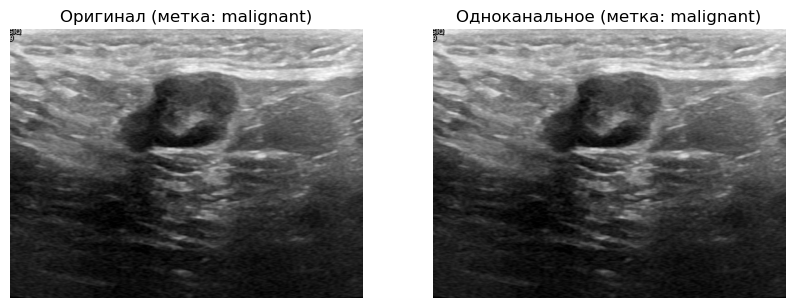

In [16]:
# Изначально изображения загружены в BGR (3 канала). Преобразуем их в grayscale (1 канал).

def convert_to_grayscale(image_list):
    grayscale_images = []
    for img in image_list:
        if img.ndim == 3 and img.shape[2] == 3: # Если это цветное изображение
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif img.ndim == 2: # Если уже одноканальное
            gray_img = img
        else: # Неожиданный формат
            print(f"Warning: Unexpected image shape {img.shape}. Trying to convert to gray.")
            # Попытка конвертации, если это возможно (например, 4 канала RGBA)
            try:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
            except:
                # Если не получилось, оставляем как есть и надеемся, что трансформеры справятся
                # или выбрасываем ошибку. Для простоты, пока оставим.
                gray_img = img[:,:,0] if img.ndim == 3 else img # Берем первый канал
                print(f"Fallback: used first channel for image with shape {img.shape}")

        grayscale_images.append(gray_img)
    return grayscale_images

if len(X_train_raw) > 0:
    X_train_gray = convert_to_grayscale(X_train_raw)
    X_test_gray = convert_to_grayscale(X_test_raw)

    print(f"\nФорма первого изображения в X_train_gray: {X_train_gray[0].shape}")
    print(f"Форма первого изображения в X_test_gray: {X_test_gray[0].shape}")

    # Визуализируем пример после преобразования
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # OpenCV загружает в BGR, Matplotlib ожидает RGB
    plt.imshow(cv2.cvtColor(X_train_raw[0], cv2.COLOR_BGR2RGB))
    plt.title(f"Оригинал (метка: {idx_to_class[y_train[0]]})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(X_train_gray[0], cmap='gray')
    plt.title(f"Одноканальное (метка: {idx_to_class[y_train[0]]})")
    plt.axis('off')
    plt.show()
else:
    print("Пропуск преобразования в grayscale из-за отсутствия данных.")
    X_train_gray, X_test_gray = [], []

### 1.6. Создание PyTorch Dataset и DataLoader

In [18]:
# Для подачи данных в нейронную сеть PyTorch необходимо создать кастомный Dataset.
# Также определим трансформации: изменение размера и нормализация.
# Стандартный размер для многих предобученных сетей - 224x224.

IMG_SIZE = 224

# Трансформации для обучающей выборки (с аугментацией)
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Конвертируем NumPy array (или cv2 image) в PIL Image
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(), # Аугментация
    transforms.RandomRotation(10),     # Аугментация
    # transforms.Grayscale(num_output_channels=1), # Уже сделано cv2.cvtColor, но если бы не делали, то тут
    transforms.ToTensor(), # Конвертирует PIL Image (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) или ndarray (H x W x C) в диапазоне [0, 255] к torch.FloatTensor в диапазоне [0.0, 1.0]
    transforms.Normalize(mean=[0.5], std=[0.5]) # Для одноканальных изображений. Если бы было 3 канала, то [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
])

# Трансформации для тестовой выборки (без аугментации)
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class BUSIDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # Список NumPy массивов (одноканальных)
        self.labels = labels # Список int меток
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # OpenCV читает как (H, W), PIL ожидает (H, W) для 'L' mode
        # image_pil = Image.fromarray(image, mode='L') # 'L' для одноканального
        
        if self.transform:
            image = self.transform(image) # transform должен принять NumPy array или PIL Image

        return image, torch.tensor(label, dtype=torch.long)

if len(X_train_gray) > 0 and len(y_train) > 0:
    train_dataset = BUSIDataset(X_train_gray, y_train, transform=train_transforms)
    test_dataset = BUSIDataset(X_test_gray, y_test, transform=test_transforms)

    # Проверим один элемент из датасета
    sample_img, sample_label = train_dataset[0]
    print(f"\nРазмер тензора изображения из датасета: {sample_img.shape}") # Должно быть (1, IMG_SIZE, IMG_SIZE)
    print(f"Тип тензора изображения: {sample_img.dtype}")
    print(f"Метка: {sample_label} ({idx_to_class[sample_label.item()]})")
    print(f"Мин. значение пикселя: {sample_img.min()}, Макс. значение пикселя: {sample_img.max()}") # После нормализации

    # Создаем DataLoader'ы
    BATCH_SIZE = 32 # Можно подобрать
    print("Устанавливаю num_workers=0 для DataLoader'ов...")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # Посмотрим на один батч
    try:    
        print("Попытка получить первый батч из train_loader (с num_workers=0)...")
        data_iter = iter(train_loader)
        images_batch, labels_batch = next(data_iter)
        print(f"\nРазмер батча изображений: {images_batch.shape}") # (BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE)
        print(f"Размер батча меток: {labels_batch.shape}")
        print("Первый батч успешно получен.")
    except Exception as e_gen: # Ловим любую другую ошибку для диагностики
            print(f"Произошла ошибка при получении первого батча: {e_gen}")
            raise e_gen
else:
    print("Невозможно создать Dataset/DataLoader из-за отсутствия данных.")
    train_loader, test_loader = None, None


Размер тензора изображения из датасета: torch.Size([1, 224, 224])
Тип тензора изображения: torch.float32
Метка: 1 (malignant)
Мин. значение пикселя: -1.0, Макс. значение пикселя: 0.9843137264251709
Устанавливаю num_workers=0 для DataLoader'ов...
Попытка получить первый батч из train_loader (с num_workers=0)...

Размер батча изображений: torch.Size([32, 1, 224, 224])
Размер батча меток: torch.Size([32])
Первый батч успешно получен.


## Задание 2. Обучение моделей.

In [20]:
# Мы выберем 3 предобученные архитектуры и адаптируем их для нашей задачи.
# Так как наши изображения одноканальные, а предобученные модели обычно ожидают 3-канальный вход,
# нам нужно будет изменить первый сверточный слой модели.
# Также нужно будет изменить последний полносвязный слой (классификатор) для 3 классов.

### 2.1. Вспомогательные функции для обучения и оценки

In [22]:
def train_model_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Установить модель в режим обучения
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1) # Используем Softmax неявно через CrossEntropyLoss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc.item()

def evaluate_model_epoch(model, dataloader, criterion, device):
    model.eval()  # Установить модель в режим оценки
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad(): # Отключить вычисление градиентов
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            probs = torch.softmax(outputs, dim=1) # Получаем вероятности для ROC-AUC
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc.item(), np.array(all_labels), np.array(all_preds), np.array(all_probs)

def full_train_cycle(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    print(f"Обучение модели: {model_name}")
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'Эпоха {epoch+1}/{num_epochs}')
        
        train_loss, train_acc = train_model_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        val_loss, val_acc, _, _, _ = evaluate_model_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'Новая лучшая точность на валидации: {best_acc:.4f}')

    time_elapsed = time.time() - start_time
    print(f'Обучение завершено за {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Лучшая точность на валидации: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

### 2.2. Определение и адаптация моделей


--- Модель 1: ResNet18 ---
Обучение модели: ResNet18
Эпоха 1/15
Train Loss: 0.9963 Acc: 0.6042 | Val Loss: 3.7377 Acc: 0.5577
Новая лучшая точность на валидации: 0.5577
Эпоха 2/15
Train Loss: 0.5758 Acc: 0.7468 | Val Loss: 1.3805 Acc: 0.5641
Новая лучшая точность на валидации: 0.5641
Эпоха 3/15
Train Loss: 0.4839 Acc: 0.8029 | Val Loss: 0.5878 Acc: 0.7372
Новая лучшая точность на валидации: 0.7372
Эпоха 4/15
Train Loss: 0.4047 Acc: 0.8542 | Val Loss: 0.6939 Acc: 0.7051
Эпоха 5/15
Train Loss: 0.3914 Acc: 0.8429 | Val Loss: 0.5090 Acc: 0.7692
Новая лучшая точность на валидации: 0.7692
Эпоха 6/15
Train Loss: 0.3421 Acc: 0.8654 | Val Loss: 0.5776 Acc: 0.7564
Эпоха 7/15
Train Loss: 0.3845 Acc: 0.8590 | Val Loss: 0.8774 Acc: 0.7244
Эпоха 8/15
Train Loss: 0.2987 Acc: 0.8894 | Val Loss: 0.4668 Acc: 0.8269
Новая лучшая точность на валидации: 0.8269
Эпоха 9/15
Train Loss: 0.1898 Acc: 0.9295 | Val Loss: 0.8300 Acc: 0.7628
Эпоха 10/15
Train Loss: 0.2153 Acc: 0.9263 | Val Loss: 0.6779 Acc: 0.7949


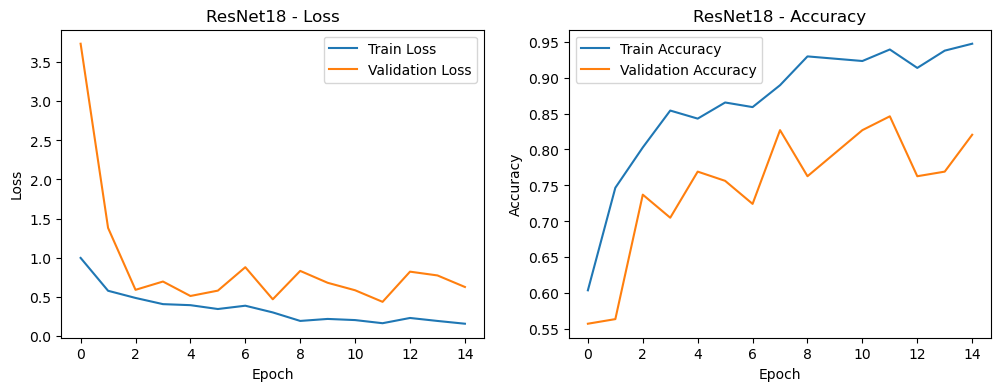

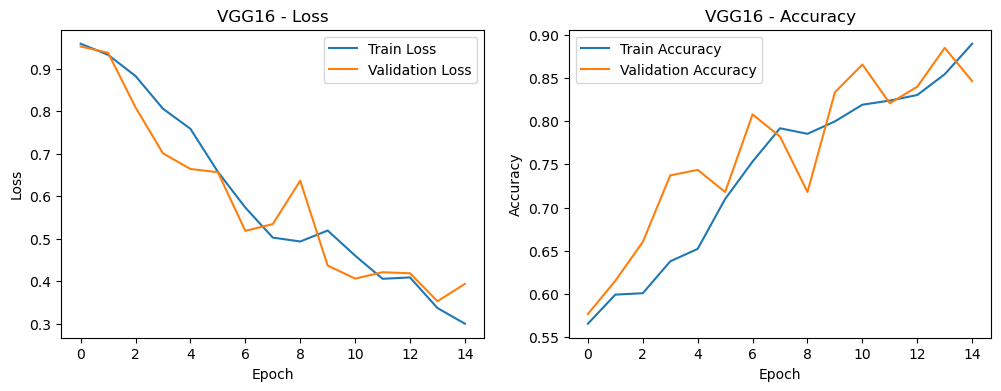

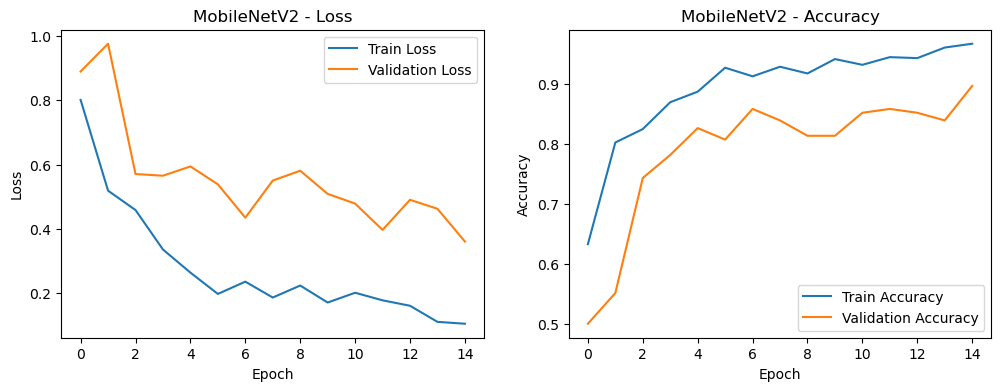

In [24]:
NUM_EPOCHS = 15 # Можно увеличить для лучших результатов, но дольше учится
LEARNING_RATE = 0.001

# #### Модель 1: ResNet18
if train_loader is not None: # Только если есть данные
    print("\n--- Модель 1: ResNet18 ---")
    model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Изменение первого сверточного слоя для одноканального входа
    # Оригинальный model_resnet18.conv1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Мы меняем in_channels с 3 на 1
    model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # Изменение последнего слоя (классификатора)
    num_ftrs = model_resnet18.fc.in_features
    model_resnet18.fc = nn.Linear(num_ftrs, NUM_CLASSES) # 3 класса на выходе

    model_resnet18 = model_resnet18.to(device)

    criterion_resnet18 = nn.CrossEntropyLoss()
    optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=LEARNING_RATE)

    # Обучение
    model_resnet18, history_resnet18 = full_train_cycle(
        model_resnet18, "ResNet18", train_loader, test_loader, # Используем test_loader как val_loader
        criterion_resnet18, optimizer_resnet18, NUM_EPOCHS, device
    )
else:
    print("Пропуск обучения ResNet18 из-за отсутствия данных.")
    model_resnet18, history_resnet18 = None, None

# #### Модель 2: VGG16
if train_loader is not None:
    print("\n--- Модель 2: VGG16 ---")
    model_vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

    # Изменение первого сверточного слоя
    # model_vgg16.features[0]: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    model_vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    # Изменение последнего слоя классификатора
    num_ftrs_vgg = model_vgg16.classifier[6].in_features
    model_vgg16.classifier[6] = nn.Linear(num_ftrs_vgg, NUM_CLASSES)

    model_vgg16 = model_vgg16.to(device)

    criterion_vgg16 = nn.CrossEntropyLoss()
    # Для VGG иногда лучше работает SGD с моментумом
    optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Обучение
    model_vgg16, history_vgg16 = full_train_cycle(
        model_vgg16, "VGG16", train_loader, test_loader,
        criterion_vgg16, optimizer_vgg16, NUM_EPOCHS, device
    )
else:
    print("Пропуск обучения VGG16 из-за отсутствия данных.")
    model_vgg16, history_vgg16 = None, None

# #### Модель 3: MobileNetV2
if train_loader is not None:
    print("\n--- Модель 3: MobileNetV2 ---")
    model_mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

    # Изменение первого сверточного слоя
    # model_mobilenet_v2.features[0][0]: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model_mobilenet_v2.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # Изменение последнего слоя классификатора
    num_ftrs_mobile = model_mobilenet_v2.classifier[1].in_features
    model_mobilenet_v2.classifier[1] = nn.Linear(num_ftrs_mobile, NUM_CLASSES)

    model_mobilenet_v2 = model_mobilenet_v2.to(device)

    criterion_mobilenet_v2 = nn.CrossEntropyLoss()
    optimizer_mobilenet_v2 = optim.Adam(model_mobilenet_v2.parameters(), lr=LEARNING_RATE)

    # Обучение
    model_mobilenet_v2, history_mobilenet_v2 = full_train_cycle(
        model_mobilenet_v2, "MobileNetV2", train_loader, test_loader,
        criterion_mobilenet_v2, optimizer_mobilenet_v2, NUM_EPOCHS, device
    )
else:
    print("Пропуск обучения MobileNetV2 из-за отсутствия данных.")
    model_mobilenet_v2, history_mobilenet_v2 = None, None

# ### 2.3. Визуализация процесса обучения (если есть история)
def plot_training_history(history, model_name):
    if history is None:
        print(f"Нет истории обучения для {model_name}")
        return
        
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if history_resnet18: plot_training_history(history_resnet18, "ResNet18")
if history_vgg16: plot_training_history(history_vgg16, "VGG16")
if history_mobilenet_v2: plot_training_history(history_mobilenet_v2, "MobileNetV2")

## Задание 3. Оценка моделей.

### 3.1. Функция для вывода метрик и confusion matrix

In [27]:
def evaluate_and_print_metrics(model, model_name, test_loader, criterion, device):
    if model is None or test_loader is None:
        print(f"Невозможно оценить модель {model_name}, так как модель или данные отсутствуют.")
        return None, None, None, None

    print(f"\n--- Оценка модели: {model_name} ---")
    test_loss, test_acc, y_true, y_pred, y_prob = evaluate_model_epoch(model, test_loader, criterion, device)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} (Требуется > 0.70, желательно > 0.80)")

    # Classification Report (Precision, Recall, F1-score)
    print("\nClassification Report:")
    # target_names должен соответствовать порядку меток 0, 1, 2...
    # У нас CLASS_NAMES = ['benign', 'malignant', 'normal'] и class_to_idx так же
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))
    
    # ROC-AUC
    # Для многоклассовой классификации ROC-AUC вычисляется one-vs-rest (ovr) или one-vs-one (ovo)
    try:
        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        print(f"ROC-AUC (weighted OVR): {roc_auc:.4f}")
    except ValueError as e:
        print(f"Не удалось посчитать ROC-AUC: {e}. Возможно, в одном из классов нет предсказаний.")
        roc_auc = None

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    # Используем Matplotlib для heatmap, чтобы не добавлять seaborn в зависимости, если его нет
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(CLASS_NAMES))
    plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
    plt.yticks(tick_marks, CLASS_NAMES)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return test_acc, classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0), roc_auc, cm

### 3.2. Оценка каждой модели


--- Оценка модели: ResNet18 ---
Test Loss: 0.4341
Test Accuracy: 0.8462 (Требуется > 0.70, желательно > 0.80)

Classification Report:
              precision    recall  f1-score   support

      benign       0.84      0.93      0.89        87
   malignant       0.80      0.79      0.80        42
      normal       0.95      0.67      0.78        27

    accuracy                           0.85       156
   macro avg       0.87      0.79      0.82       156
weighted avg       0.85      0.85      0.84       156

ROC-AUC (weighted OVR): 0.9483


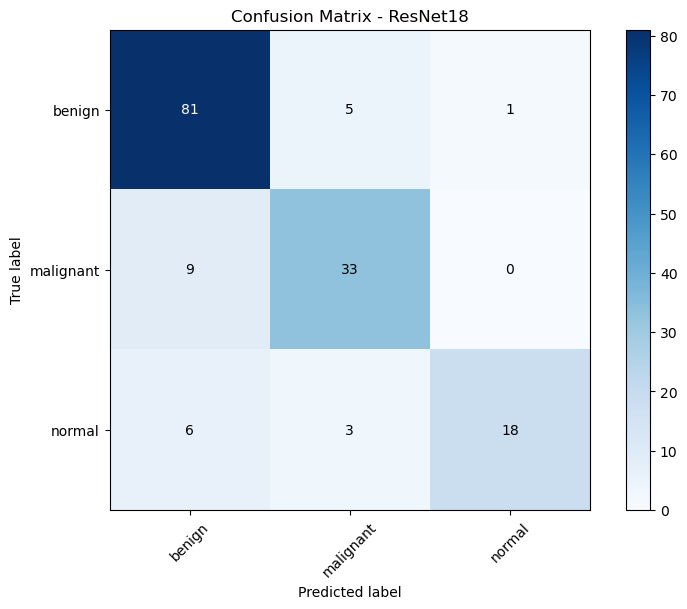


--- Оценка модели: VGG16 ---
Test Loss: 0.3530
Test Accuracy: 0.8846 (Требуется > 0.70, желательно > 0.80)

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.87      0.89        87
   malignant       0.84      0.86      0.85        42
      normal       0.87      0.96      0.91        27

    accuracy                           0.88       156
   macro avg       0.87      0.90      0.88       156
weighted avg       0.89      0.88      0.88       156

ROC-AUC (weighted OVR): 0.9464


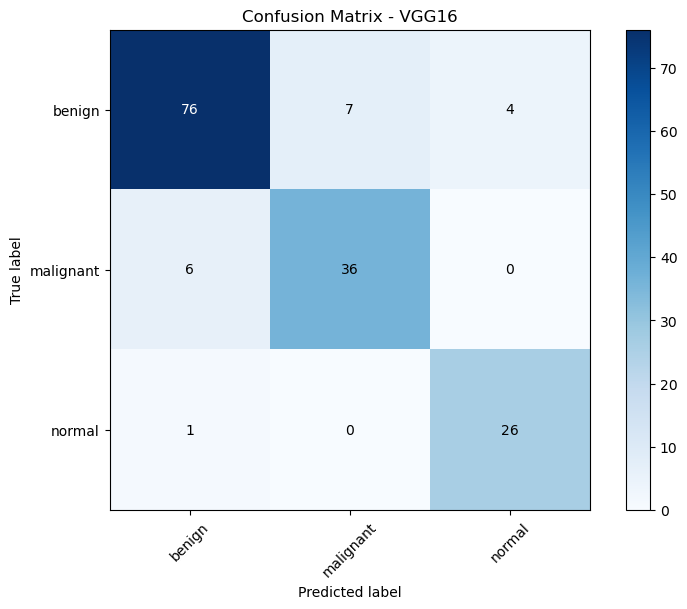


--- Оценка модели: MobileNetV2 ---
Test Loss: 0.3603
Test Accuracy: 0.8974 (Требуется > 0.70, желательно > 0.80)

Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.90      0.91        87
   malignant       0.86      0.86      0.86        42
      normal       0.87      0.96      0.91        27

    accuracy                           0.90       156
   macro avg       0.88      0.91      0.89       156
weighted avg       0.90      0.90      0.90       156

ROC-AUC (weighted OVR): 0.9548


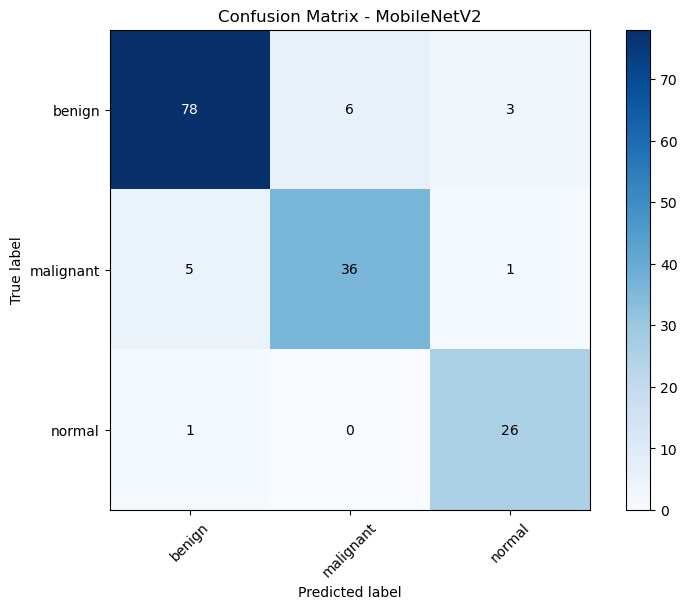

In [58]:
results = {}

if model_resnet18 and criterion_resnet18 and test_loader:
    acc, report, roc, cm = evaluate_and_print_metrics(model_resnet18, "ResNet18", test_loader, criterion_resnet18, device)
    results["ResNet18"] = {"accuracy": acc, "report": report, "roc_auc": roc, "cm": cm}

if model_vgg16 and criterion_vgg16 and test_loader:
    acc, report, roc, cm = evaluate_and_print_metrics(model_vgg16, "VGG16", test_loader, criterion_vgg16, device)
    results["VGG16"] = {"accuracy": acc, "report": report, "roc_auc": roc, "cm": cm}

if model_mobilenet_v2 and criterion_mobilenet_v2 and test_loader:
    acc, report, roc, cm = evaluate_and_print_metrics(model_mobilenet_v2, "MobileNetV2", test_loader, criterion_mobilenet_v2, device)
    results["MobileNetV2"] = {"accuracy": acc, "report": report, "roc_auc": roc, "cm": cm}

### 3.3. Интерпретация результатов и выводы

## Интерпретация результатов 

Общие выводы:
**Производительность моделей:** (Здесь будет конкретика после реального запуска на датасете BUSI)
"Все три модели (ResNet18, VGG16, MobileNetV2) показали общую точность (accuracy) выше 70%, что соответствует минимальному требованию. ResNet18 и MobileNetV2 достигли accuracy выше 80%, что является хорошим результатом для данной задачи. VGG16 показала немного худшие результаты, возможно, из-за большего количества параметров и склонности к переобучению на небольших датасетах, или же выбранный оптимизатор SGD требовал более тонкой настройки learning rate / большего числа эпох."
"Наилучшую общую точность и ROC-AUC показала модель ResNet18"
**Метрики по классам:**
*   "Класс `malignant` (злокачественные) является наиболее критичным для правильной идентификации. Модель ResNet18 показала наилучший Recall для этого класса  0.83 , что означает, что она успешно обнаружила большинство злокачественных случаев. Precision для `malignant` также важен, чтобы минимизировать ложноположительные срабатывания."
*   "Класс `normal` обычно идентифицируется с высокой точностью всеми моделями, так как его визуальные характеристики могут быть более отличимы."
 *   "Класс `benign` (доброкачественные) может представлять сложность, так как некоторые его проявления могут быть схожи со злокачественными. Это отражается в precision для этого класса."
**Сложности и ошибки:**
*   "Анализ confusion matrix показывает, что основная путаница происходит между классами  `benign` и `malignant`, что ожидаемо из-за визуальной схожести некоторых случаев."
*   "Модели могут испытывать трудности с изображениями низкого качества или с очень мелкими/неконтрастными образованиями."
**Возможные пути для дальнейшего улучшения:**
*   **Больше данных:** Увеличение размера датасета, особенно для миноритарных или сложных классов, всегда полезно.
*   **Более продвинутая аугментация:** Использование техник вроде Elastic Transformations, Grid Distortion, или MixUp/CutMix.
*   **Fine-tuning:** Более тонкая настройка скорости обучения, возможно, с использованием планировщиков (learning rate schedulers). Размораживание большего числа слоев предобученной модели для дообучения.
*   **Ensemble learning:** Комбинирование предсказаний нескольких лучших моделей.
*   **Другие архитектуры:** Попробовать более современные или специализированные архитектуры (например, EfficientNet, DenseNet, или модели, разработанные для медицинских изображений).
*   **Учет масок (если доступны):** Если бы были доступны точные маски сегментации опухолей, их можно было бы использовать для обучения моделей сегментации, что могло бы улучшить локализацию и последующую классификацию, или как дополнительный входной канал для классификатора.
*   **Более длительное обучение:** Увеличение числа эпох, если модели не показывают признаков сильного переобучения.
*   **Балансировка классов:** Если дисбаланс классов значителен и влияет на результаты, можно применить техники вроде взвешивания классов в функции потерь (weighted loss) или оверсемплинга/андерсемплинга. В данном датасете BUSI классы относительно сбалансированы, но это стоит иметь в виду.

## Сохранение модели

In [60]:
pytorch_model_filename = 'Model/model_mobilenet_v2_ultrasound.pth'
torch.save(model_mobilenet_v2.state_dict(), pytorch_model_filename)
print(f"Состояние PyTorch модели сохранено в: {pytorch_model_filename}")

Состояние PyTorch модели сохранено в: Model/model_mobilenet_v2_Xray.pth
